In [1]:
import os
os.chdir('/home/arunesh_mitl_gmail_com/floater/DissertationProjects/prototypical_metric_learning/')

In [2]:
import pickle 
import numpy as np

# Load ABIDE-150 data with 80 dimensional dictionary elements 
data_dict = pickle.load(open( "./preprocessed_data/abide_dl_80_data.pkl", "rb"))
ys = data_dict['ys'] - 1
xs = data_dict['zs'] # Dictionary learning loadings treated as data

MemoryError: 

In [ ]:
from utils.eval import get_eval_metrics, get_cv_metrics
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.decomposition import PCA

def get_knn_metrics(xs_train, ys_train, xs_test, ys_test, z_dim=10):
    
    pca = PCA(n_components=z_dim)
    
    zs_train = pca.fit_transform(xs_train.reshape(-1, xs_train.shape[-1]))
    zs_train = zs_train.reshape(xs_train.shape[0], xs_train.shape[1], z_dim)

    zs_test = pca.transform(xs_test.reshape(-1, xs_test.shape[-1]))
    zs_test = zs_test.reshape(xs_test.shape[0], xs_test.shape[1], z_dim)
    
    # Trian k-NN classifier
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(zs_train.reshape(-1, z_dim), np.tile(ys_train[:,None], (1, xs_train.shape[1])).reshape(-1))
    
    # Use k-NN to classify each volume
    # then use majority vote to classify each sequence
    y_train_pred = []
    for z in zs_train:
        c = Counter(neigh.predict(z))
        value, count = c.most_common()[0]
        y_train_pred.append(value)
    
    train_metrics = get_eval_metrics(ys_train, y_train_pred)
    
    # Repeat for held-out data
    y_test_pred = []
    for z in zs_test:
        c = Counter(neigh.predict(z))
        value, count = c.most_common()[0]
        y_test_pred.append(value)

    test_metrics = get_eval_metrics(ys_test, y_test_pred)

    return train_metrics, test_metrics, zs_train, ys_train, zs_test, ys_test

In [3]:
N_SPLITS = 5
N_EPOCHS = 1
Z_DIM = 10
TEST_MODE = False

In [5]:
from sklearn.model_selection import StratifiedKFold

losses = []
ho_losses = []
train_metrics_lst = []
test_metrics_lst = []
cached_anchors = []

kf = StratifiedKFold(n_splits=N_SPLITS)

for i, (train_index, test_index) in enumerate(kf.split(xs, ys)):
    if TEST_MODE and i > 0:
        print('!!!TEST MODE!!!')
        break
    losses.append([])
    ho_losses.append([])
    train_metrics_lst.append([])
    test_metrics_lst.append([])

    print(f'Fold {i+1} of {N_SPLITS}')
    xs_train, xs_test = xs[train_index], xs[test_index]
    ys_train, ys_test = ys[train_index], ys[test_index]


    for i in range(N_EPOCHS):
        if i % 20 == 0:
            print(f'Epoch {i+1} of {N_EPOCHS}')
        
        if i % 50 == 0:
            train_metrics, test_metrics, zs_train, ys_train, zs_test, ys_test = get_knn_metrics(xs_train, ys_train, xs_test, ys_test, Z_DIM)
            print(train_metrics)
            print(test_metrics)
            train_metrics_lst[-1].append(train_metrics)
            test_metrics_lst[-1].append(test_metrics)

    cached_anchors.append(zs_train)

Fold 1 of 5
Epoch 1 of 1
{'acc': 0.9916666666666667, 'sen': 0.9836065573770492, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.9833333333333333}
{'acc': 0.5666666666666667, 'sen': 0.13333333333333333, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.5357142857142857}
Fold 2 of 5
Epoch 1 of 1
{'acc': 0.9916666666666667, 'sen': 0.9836065573770492, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.9833333333333333}
{'acc': 0.6666666666666666, 'sen': 0.3333333333333333, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.6}
Fold 3 of 5
Epoch 1 of 1
{'acc': 0.9833333333333333, 'sen': 0.9672131147540983, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.9672131147540983}
{'acc': 0.5666666666666667, 'sen': 0.13333333333333333, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.5357142857142857}
Fold 4 of 5
Epoch 1 of 1
{'acc': 0.9916666666666667, 'sen': 0.9836065573770492, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.9833333333333333}
{'acc': 0.6666666666666666, 'sen': 0.3333333333333333, 'spe': 1.0, 'ppv': 1.0, 'npv': 0.6}
Fold 5 of 5
Epoch 1 of 1
{'acc': 1.0, 'sen': 1.0, 'spe': 1.0, 'ppv': 1.0, 'npv':

In [7]:
cv_results = [t[0] for t in train_metrics_lst]

metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print('--------------------- Train [Acc/Sen/Spec] ---------------------')
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')

cv_results = [t[0] for t in test_metrics_lst]

metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print('\n--------------------- Test [Acc/Sen/Spec] ---------------------')
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')

--------------------- Train [Acc/Sen/Spec] ---------------------
	0.992±0.005	0.984±0.010	1.000±0.000

--------------------- Test [Acc/Sen/Spec] ---------------------
	0.593±0.065	0.199±0.113	1.000±0.000


### Visualization

In [8]:
from matplotlib import pyplot as plt

zs_test = zs_test.reshape(-1, Z_DIM)
ys_test_in = np.tile(ys_test[:, None], (1,78)).reshape(-1)

In [12]:
import umap
um = umap.UMAP(n_neighbors=5,
                      min_dist=0.1,
                      metric='euclidean').fit(zs_test)
embeddings = um.transform(zs_test)

([], [])

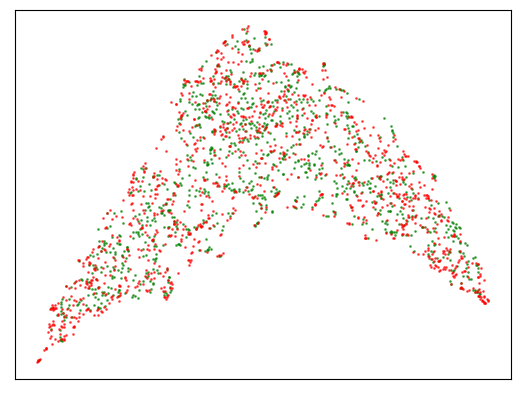

In [14]:
plt.figure()
plt.scatter(embeddings[ys_test_in==0,0], embeddings[ys_test_in==0,1], color='green', s=1, alpha=.6)
plt.scatter(embeddings[ys_test_in==1,0], embeddings[ys_test_in==1,1], color='red', s=1, alpha=.6)
plt.xticks([])
plt.yticks([])